In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip -qq /content/drive/MyDrive/dermnetMini_augmented.zip

In [ ]:
import tensorflow as tf

In [ ]:
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageOps, ImageChops, ImageFilter
import random
import glob
mypath = "./dermnetMini/train/Tinea Ringworm Candidiasis and other Fungal Infections/"
#imagefiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
imagefiles = glob.glob(mypath + '*.jpg')
cnt=0

for my_image in imagefiles:
    img = Image.open(my_image)
    mirror_img = ImageOps.mirror(img)
    mirror_img.save(mypath+ str(cnt)+"_mirror.jpg")

    img_to_shift = Image.open(my_image)
    img_shifted =ImageChops.offset(img_to_shift, -800, -400)
    img_shifted.save(mypath + str(cnt) +'_shifted.jpg')
    

    
    with Image.open(my_image) as im:
        im.rotate(120).save(mypath+str(cnt) +"_rotated.jpg")


        
    cnt=cnt+1


In [3]:
trainPath="dermnetMini/train"
testPath="dermnetMini/test"

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, AveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing import image
import numpy as np
import os
import datetime
%matplotlib inline

In [5]:
batch_size=128
img_height = 96
img_width = 96

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  trainPath,
  #color_mode='grayscale',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13440 files belonging to 4 classes.
Using 10752 files for training.


In [6]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  trainPath, 
  #color_mode='grayscale',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 13440 files belonging to 4 classes.
Using 2688 files for validation.


In [7]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  testPath,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4828 files belonging to 4 classes.


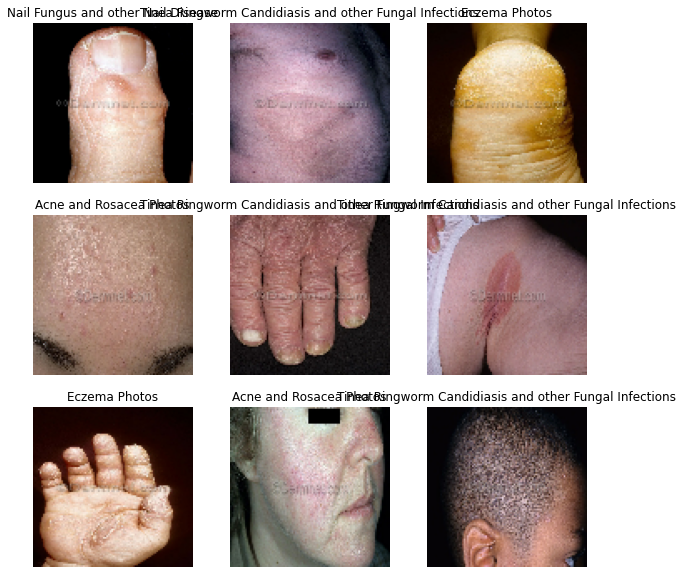

In [ ]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
data_augmentation= Sequential([
                               
                               layers.RandomFlip("horizontal"),
                               layers.RandomRotation(0.5),
                               layers.RandomZoom(0.4),
])

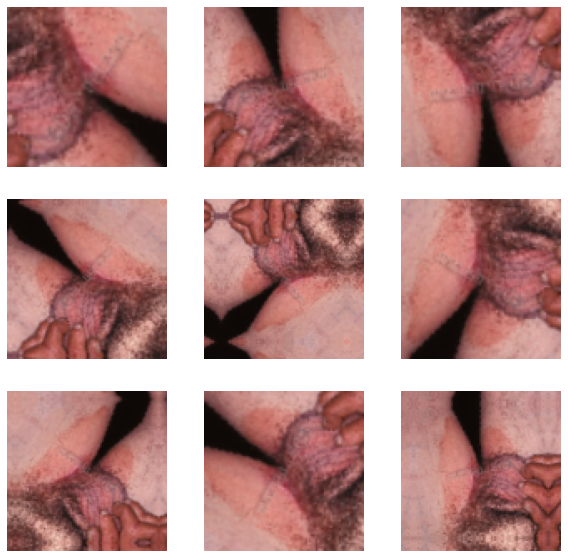

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
x_train= tf.concat([x for x, y in train_ds], axis=0)
y_train= tf.concat([y for x, y in train_ds], axis=0)

In [ ]:
x_val= tf.concat([x for x, y in val_ds], axis=0)
y_val= tf.concat([y for x, y in val_ds], axis=0)

In [ ]:
x_test= tf.concat([x for x, y in test_ds], axis=0)
y_test= tf.concat([y for x, y in test_ds], axis=0)

In [ ]:
x_train /= 255
x_test /= 255
x_val /= 255

In [8]:
from tensorflow.keras import regularizers

In [9]:
model = Sequential([
        #data_augmentation,
        layers.experimental.preprocessing.Rescaling(1./255),
        Conv2D(16, 3, activation='relu', padding='SAME'),
        MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.DepthwiseConv2D(8, 3, activation='relu', padding='SAME'),
        MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.DepthwiseConv2D(8, 3, activation='relu', padding='SAME'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(units=4, activation='softmax'),
    ])

In [10]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [11]:
history = model.fit(train_ds, validation_data=val_ds, epochs=50, batch_size=batch_size)

Epoch 1/50
84/84 [==============================] - 32s 233ms/step - loss: 1.3773 - accuracy: 0.2825 - val_loss: 1.3543 - val_accuracy: 0.3404
Epoch 2/50
84/84 [==============================] - 20s 225ms/step - loss: 1.3237 - accuracy: 0.3670 - val_loss: 1.2922 - val_accuracy: 0.4159
Epoch 3/50
84/84 [==============================] - 21s 235ms/step - loss: 1.2612 - accuracy: 0.4197 - val_loss: 1.2317 - val_accuracy: 0.4501
Epoch 4/50
84/84 [==============================] - 21s 225ms/step - loss: 1.2091 - accuracy: 0.4567 - val_loss: 1.1932 - val_accuracy: 0.4840
Epoch 5/50
84/84 [==============================] - 20s 226ms/step - loss: 1.1779 - accuracy: 0.4806 - val_loss: 1.1765 - val_accuracy: 0.4996
Epoch 6/50
84/84 [==============================] - 20s 227ms/step - loss: 1.1547 - accuracy: 0.5008 - val_loss: 1.1576 - val_accuracy: 0.5126
Epoch 7/50
84/84 [==============================] - 20s 225ms/step - loss: 1.1353 - accuracy: 0.5186 - val_loss: 1.1530 - val_accuracy: 0.5037

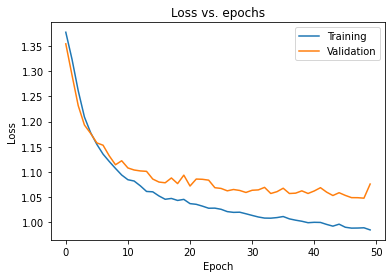

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

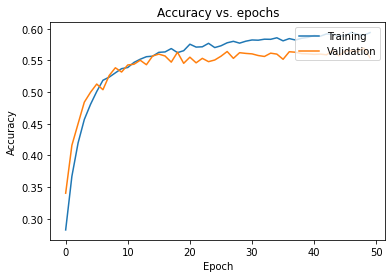

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [14]:
model.save("dermnet.h5")

In [15]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("dermnet_model.tflite", "wb").write(tflite_model)
  
import os
basic_model_size = os.path.getsize("dermnet_model.tflite")
print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /tmp/tmp8mohdi5w/assets


Model is 13976 bytes


In [16]:
!apt-get install xxd

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xxd
0 upgraded, 1 newly installed, 0 to remove and 62 not upgraded.
Need to get 49.9 kB of archives.
After this operation, 201 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/main amd64 xxd amd64 2:8.0.1453-1ubuntu1.8 [49.9 kB]
Fetched 49.9 kB in 0s (181 kB/s)
Selecting previously unselected package xxd.
(Reading database ... 155639 files and directories currently installed.)
Preparing to unpack .../xxd_2%3a8.0.1453-1ubuntu1.8_amd64.deb ...
Unpacking xxd (2:8.0.1453-1ubuntu1.8) ...
Setting up xxd (2:8.0.1453-1ubuntu1.8) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [17]:
!echo "const unsigned char model[] = {" > ./model.h
!cat dermnet_model.tflite | xxd -i      >> ./model.h
!echo "};"                              >> ./model.h

In [18]:
import os
model_h_size = os.path.getsize("model.h")
print(f"Header file, model.h, is {model_h_size:,} bytes.")

Header file, model.h, is 86,220 bytes.
